In [21]:
import pandas as pd
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold, GridSearchCV
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

from sklearn.linear_model import BayesianRidge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.neighbors import KNeighborsRegressor
import matplotlib.pyplot as plt
import seaborn as sns
from dotenv import load_dotenv
import os
import numpy as np

from sklearn.ensemble import RandomForestClassifier

In [22]:
# Import dataset
load_dotenv()
dataset_path=os.getenv("DATASET_PATH_TWO_P")
dataset = pd.read_csv(dataset_path)
dataset.head()

,Gender,Age,DIAGNOSIS,MMSE,Hip ASM,Hip Contrast,Hip Correlation,Hip Variance,Hip Sum Average,Hip Sum Variance,...,ERC CONTRAST,ERC CORRELATION,ERC VARIANCE,ERC SUM AVERAGE,ERC SUM VARIANCE,ERC ENTROPY,ERC CLUSTER SHADE,ERCs_thicknessbaseline,ERCsVolumebaseline,TOTAL_HIPPOCAMPUS_VOLUME
0,0,64.585900,0,27.0,0.377501,128.715226,0.422342,115.630163,15.181458,333.805425,...,286.270009,0.289728,206.373786,44.577974,539.225137,3.320292,22924.739100,3.3445,2251,7338.2
1,0,68.076660,2,20.0,0.657212,51.830551,0.557254,84.225204,8.530596,285.070266,...,282.873623,0.310507,206.276556,39.697933,542.232602,2.864138,18182.687670,2.9605,2924,5438.6
2,1,76.221760,1,28.0,0.520032,86.558742,0.594543,123.662642,13.400504,408.091827,...,244.274039,0.370189,201.216707,46.081559,560.592790,3.415186,28045.350990,3.3145,4042,8434.4
3,0,73.221085,0,30.0,0.396133,60.731686,0.596733,122.546512,15.571183,429.454361,...,226.713342,0.517430,232.983710,30.461877,705.221498,2.937422,1196.160472,3.1505,3485,7476.2
4,0,45.872690,0,30.0,0.404800,108.808540,0.520363,98.065558,13.483247,283.453692,...,202.074647,0.354851,169.528802,50.680275,476.040561,3.017047,47743.254120,3.5420,3964,8021.8


In [23]:
X_train, X_test, y_train, y_test = train_test_split(
    dataset.drop("DIAGNOSIS", axis=1),  
    dataset["DIAGNOSIS"],  
    test_size=0.3,  
    random_state=42,  
)

In [24]:
imputer_bayes = IterativeImputer(
    estimator=BayesianRidge(),
    random_state=42,
)

imputer_knn = IterativeImputer(
    estimator=KNeighborsRegressor(),
    random_state=42,
)

imputer_nonLin = IterativeImputer(
    estimator=DecisionTreeRegressor(),
    random_state=42,
)

imputer_missForest = IterativeImputer(
    estimator=ExtraTreesRegressor(),
    random_state=42,
)

In [25]:
imputer_bayes.fit(X_train)
imputer_knn.fit(X_train)

imputer_nonLin.fit(X_train)
imputer_missForest.fit(X_train)

IterativeImputer(estimator=ExtraTreesRegressor(), random_state=42)

In [26]:
# replace NA
X_train_bayes = imputer_bayes.transform(X_train)
X_test_bayes = imputer_bayes.transform(X_test)

X_train_knn = imputer_knn.transform(X_train)
X_test_knn = imputer_knn.transform(X_test)

X_train_nonLin = imputer_nonLin.transform(X_train)
X_test_nonLin = imputer_nonLin.transform(X_test)

X_train_missForest = imputer_missForest.transform(X_train)
X_test_missForest = imputer_missForest.transform(X_test)

In [27]:
X_train_bayes_t = pd.DataFrame(X_train_bayes, columns=X_train.columns)
X_test_bayes_t = pd.DataFrame(X_test_bayes, columns=X_test.columns)

X_train_knn_t = pd.DataFrame(X_train_knn, columns=X_train.columns)
X_test_knn_t = pd.DataFrame(X_test_knn, columns=X_test.columns)

X_train_nonLin_t = pd.DataFrame(X_train_nonLin, columns=X_train.columns)
X_test_nonLin_t = pd.DataFrame(X_test_nonLin, columns=X_test.columns)

X_train_missForest_t = pd.DataFrame(X_train_missForest, columns=X_train.columns)
X_test_missForest_t = pd.DataFrame(X_test_missForest, columns=X_test.columns)

In [28]:
dataframes = [
    X_train_bayes_t, X_test_bayes_t, 
    X_train_knn_t, X_test_knn_t,
    X_train_nonLin_t, X_test_nonLin_t,
    X_train_missForest_t, X_test_missForest_t,
]

for df in dataframes:
    if df.isna().any().all() == False:
        print("No missing values in any dataframe")
        break
    else:
        print("Still missing values")

No missing values in any dataframe


### Stratified Cross-Validation


In [29]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.metrics import accuracy_score, roc_auc_score, recall_score, precision_score, f1_score, balanced_accuracy_score, make_scorer
import numpy as np

def run_random_forest(classifier_name, imp_method, X_train, y_train):

        # Initialize the Random Forest with class weight balancing
        rf = RandomForestClassifier(n_estimators=100,
                                    max_depth=5,
                                    random_state=42,
                                    class_weight="balanced",
        )
        
        kf = StratifiedKFold(n_splits=10,
                             shuffle=True,
                             random_state=42,
        )
        
        metrics = {"accuracy": make_scorer(accuracy_score),
                   "balanced_accuracy": make_scorer(balanced_accuracy_score),  
                   "precision": make_scorer(precision_score, average="weighted", zero_division=0), 
                   "recall": make_scorer(recall_score, average="weighted", zero_division=0), 
                   "f1_weighted": make_scorer(f1_score, average="weighted", zero_division=0),
                   "roc_auc_ovr_weighted": make_scorer(roc_auc_score, 
                                                       average="weighted", 
                                                       multi_class="ovr", 
                                                       response_method="predict_proba",),
        }
        
        cross_val_results = cross_validate(rf,
                                           X_train,
                                           y_train,
                                           cv=kf,
                                           scoring=metrics,
                                           return_train_score=True,
        )
                
        metric_names = list(metrics.keys())
        mean_train = [round(np.mean(cross_val_results[f"train_{metric}"]), 3) for metric in metric_names]
        std_train = [round(np.std(cross_val_results[f"train_{metric}"]), 3) for metric in metric_names]
        mean_test = [round(np.mean(cross_val_results[f"test_{metric}"]), 3) for metric in metric_names]
        std_test = [round(np.std(cross_val_results[f"test_{metric}"]), 3) for metric in metric_names]
        time = round(np.mean(cross_val_results[f"fit_time"]), 3)
                
        cv_metrics_df = pd.DataFrame({
                "Classifier": classifier_name,
                "Imputation": imp_method,
                "Fit Time": time,
                "Metric": metric_names,
                "Mean Train": mean_train,
                "Std Train": std_train,
                "Mean Test": mean_test,
                "Std Test": std_test,
        })
        
        fit_model = rf.fit(X_train, y_train)
        
        return fit_model, cv_metrics_df


In [30]:
bayes_model, bayes_metrics = run_random_forest("Random Forest", "Ridge Bayes", X_train_bayes_t, y_train)
knn_model, knn_metrics = run_random_forest("Random Forest", "KNN Reg", X_train_knn_t, y_train)
nonLin_model, nonLin_metrics = run_random_forest("Random Forest", "NonLin", X_train_nonLin_t, y_train)
missForest_model, missForest_metrics = run_random_forest("Random Forest", "MissForest", X_train_missForest_t, y_train)

In [31]:
validation_df = pd.concat([bayes_metrics, knn_metrics, nonLin_metrics, missForest_metrics])
validation_df_report = validation_df.set_index(["Classifier", "Imputation", "Fit Time", "Metric"])
validation_df_report

Mean Train  \
Classifier    Imputation  Fit Time Metric                             
Random Forest Ridge Bayes 0.352    accuracy                   0.955   
                                   balanced_accuracy          0.938   
                                   precision                  0.955   
                                   recall                     0.955   
                                   f1_weighted                0.955   
                                   roc_auc_ovr_weighted       0.986   
              KNN Reg     0.331    accuracy                   0.952   
                                   balanced_accuracy          0.934   
                                   precision                  0.952   
                                   recall                     0.952   
                                   f1_weighted                0.952   
                                   roc_auc_ovr_weighted       0.986   
              NonLin      0.406    accuracy                   0.954   
                                   balanced_accuracy          0.938   
                                   precision                  0.954   
                                   recall                     0.954   
                                   f1_weighted                0.954   
                                   roc_auc_ovr_weighted       0.986   
              MissForest  0.354    accuracy                   0.955   
                                   balanced_accuracy          0.939   
                                   precision                  0.955   
                                   recall                     0.955   
                                   f1_weighted                0.955   
                                   roc_auc_ovr_weighted       0.987   

                                                         Std Train  Mean Test  \
Classifier    Imputation  Fit Time Metric                                       
Random Forest Ridge Bayes 0.352    accuracy                  0.007      0.823   
                                   balanced_accuracy         0.014      0.550   
                                   precision                 0.007      0.800   
                                   recall                    0.007      0.823   
                                   f1_weighted               0.007      0.806   
                                   roc_auc_ovr_weighted      0.001      0.875   
              KNN Reg     0.331    accuracy                  0.006      0.833   
                                   balanced_accuracy         0.012      0.559   
                                   precision                 0.006      0.804   
                                   recall                    0.006      0.833   
                                   f1_weighted               0.006      0.813   
                                   roc_auc_ovr_weighted      0.002      0.874   
              NonLin      0.406    accuracy                  0.007      0.831   
                                   balanced_accuracy         0.014      0.558   
                                   precision                 0.007      0.804   
                                   recall                    0.007      0.831   
                                   f1_weighted               0.007      0.813   
                                   roc_auc_ovr_weighted      0.002      0.874   
              MissForest  0.354    accuracy                  0.007      0.833   
                                   balanced_accuracy         0.014      0.564   
                                   precision                 0.007      0.807   
                                   recall                    0.007      0.833   
                                   f1_weighted               0.007      0.816   
                                   roc_auc_ovr_weighted      0.001      0.875   

                                                         Std Test  
Classifier    Imputation  Fit Time 

C:\Users\steve\AppData\Local\Temp\ipykernel_11768\265476517.py:21: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[2].legend(loc="lower right")


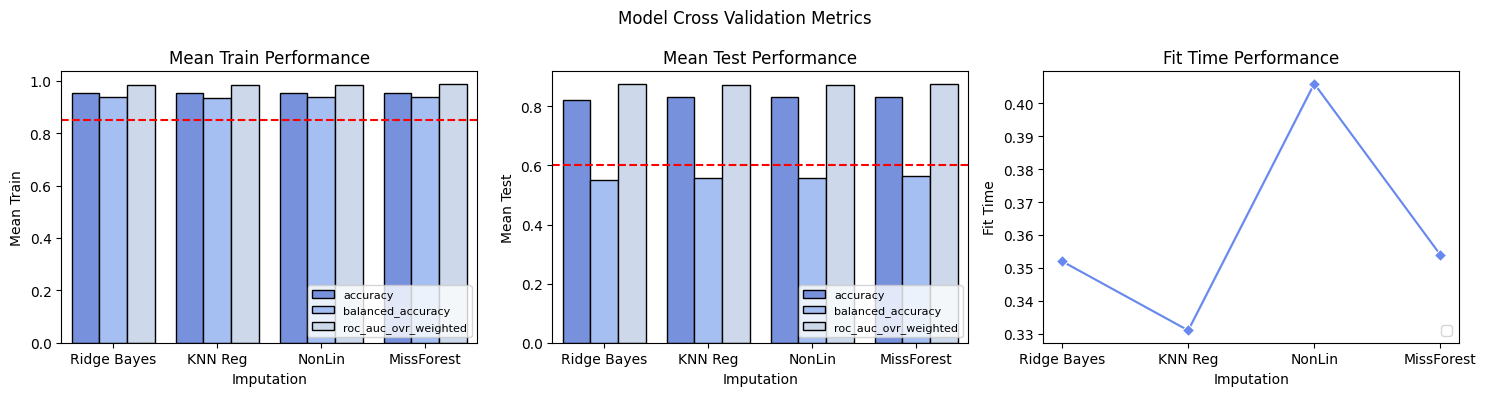

In [32]:
# Filter the metrics you want to plot (Fit Time, Accuracy, Balanced Accuracy, ROC AUC)
metrics_to_plot = ['accuracy', 'balanced_accuracy', 'roc_auc_ovr_weighted']
filtered_df_validation = validation_df[validation_df['Metric'].isin(metrics_to_plot)]
filtered_df_validation

sns.set_palette("coolwarm")
fig, axs = plt.subplots(1,3, figsize = (15, 4))

plt.suptitle("Model Cross Validation Metrics")
sns.barplot(data=filtered_df_validation, x='Imputation', y='Mean Train', hue='Metric', edgecolor='black', ax = axs[0])
axs[0].legend(loc="lower right",  fontsize=8)
axs[0].axhline(y=0.85, color='red', linestyle='--', linewidth=1.5) 
axs[0].set_title("Mean Train Performance")

sns.barplot(data=filtered_df_validation, x='Imputation', y='Mean Test', hue='Metric', edgecolor='black', ax = axs[1])
axs[1].legend(loc="lower right",  fontsize=8)
axs[1].axhline(y=0.60, color="red", linestyle="--", linewidth=1.5)
axs[1].set_title("Mean Test Performance")

sns.lineplot(data=filtered_df_validation, x='Imputation', y=filtered_df_validation['Fit Time'], marker="D", ax = axs[2])
axs[2].legend(loc="lower right")
axs[2].set_title("Fit Time Performance")

plt.tight_layout()

### Evaluate

In [33]:
from sklearn.utils import resample

def bootstrap_ci(model, X, y, metric_fn, n_iterations, ci=0.95, use_proba=False):
    scores = []
    n = len(X)
    for _ in range(n_iterations):
        X_resampled, y_resampled = resample(X, y, n_samples=n, stratify=y)
        try:
            y_pred = model.predict_proba(X_resampled) if use_proba else model.predict(X_resampled)
            score = metric_fn(y_resampled, y_pred)
            if not np.isnan(score):
                scores.append(score)
        except Exception:
            # Skip this bootstrap sample if error occurs (e.g. missing class for roc_auc)
            continue
    if len(scores) == 0:
        return (np.nan, np.nan)
    lower = np.percentile(scores, (1 - ci) / 2 * 100)
    upper = np.percentile(scores, (1 + ci) / 2 * 100)
    std_dev = np.std(scores)
    return round(lower, 3), round(upper, 3), round(std_dev, 3)

In [34]:
from sklearn.metrics import confusion_matrix

def compute_specificity(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    total = cm.sum()
    tp = np.diag(cm)
    fp = cm.sum(axis=0) - tp
    fn = cm.sum(axis=1) - tp
    tn = total - (tp + fp + fn)
    specificity = tn / (tn + fp)
    return round(np.nanmean(specificity), 3)

In [35]:
import time

def eval_random_forest(classifier_name, imp_method, model, X_train, X_test, y_train, y_test):
        
        start_time = time.time()
        # Get predicted probabilities for ROC AUC
        pred_train_proba = model.predict_proba(X_train)
        pred_test_proba = model.predict_proba(X_test)
        
        # Get predicted accuracy values
        pred_train = model.predict(X_train)
        pred_test = model.predict(X_test)
        
        metrics_train = {
                "accuracy": accuracy_score(y_train, pred_train),
                "balanced_accuracy": balanced_accuracy_score(y_train, pred_train),
                "precision_macro": precision_score(y_train, pred_train, average="macro", zero_division=0),
                "recall_macro": recall_score(y_train, pred_train, average="macro", zero_division=0),
                "f1_macro": f1_score(y_train, pred_train, average="macro", zero_division=0),
                "roc_auc_macro": roc_auc_score(y_train, pred_train_proba, average="macro", multi_class="ovr"),
                "specificity_macro": compute_specificity(y_train, pred_train),
        }

        metrics_test = {
                "accuracy": accuracy_score(y_test, pred_test),
                "balanced_accuracy": balanced_accuracy_score(y_test, pred_test),
                "precision_macro": precision_score(y_test, pred_test, average="macro", zero_division=0),
                "recall_macro": recall_score(y_test, pred_test, average="macro", zero_division=0),
                "f1_macro": f1_score(y_test, pred_test, average="macro", zero_division=0),
                "roc_auc_macro": roc_auc_score(y_test, pred_test_proba, average="macro", multi_class="ovr"),
                "specificity_macro": compute_specificity(y_test, pred_test),
        }
                
        elapsed_time = time.time() - start_time

        # Bootstrap functions
        metric_fns = {
                "accuracy": accuracy_score,
                "balanced_accuracy": balanced_accuracy_score,
                "precision_macro": lambda yt, yp: precision_score(yt, yp, average="macro", zero_division=0),
                "recall_macro": lambda yt, yp: recall_score(yt, yp, average="macro", zero_division=0),
                "f1_macro": lambda yt, yp: f1_score(yt, yp, average="macro", zero_division=0),
                "roc_auc_macro": lambda yt, yp: roc_auc_score(yt, yp, average="macro", multi_class="ovr"),
                "specificity_macro": lambda yt, yp: compute_specificity(yt, yp),
        }

        # Bootstrap confidence intervals
        ci_test = {
                m: bootstrap_ci(
                model, X_test, y_test, fn,
                n_iterations=100,
                use_proba=(m == "roc_auc_macro")
                )
                for m, fn in metric_fns.items()
        }

        # Separate CI bounds and std with clear variable names
        ci_bounds = []
        std_values = []
                
        for lower, upper, std in ci_test.values():
                ci_bounds.append(f"[{round(lower, 3)}, {round(upper, 3)}]")
                std_values.append(round(std, 3)) 
                
        # Round metric values
        train_rounded = [round(score, 3) for score in metrics_train.values()]
        test_rounded = [round(score, 3) for score in metrics_test.values()] 

        
        # Create the DataFrame without additional rounding
        pred_metrics_df = pd.DataFrame({
                "Classifier": classifier_name,
                "Imputation": imp_method,
                "Classification Time": round(elapsed_time, 3),
                "Metric": metrics_train.keys(),
                "Train data": train_rounded,
                "Test data": test_rounded,
                "95% CI": ci_bounds,
                "Std Dev": std_values,
    })
        
        return pred_metrics_df

In [36]:
pred_bayes = eval_random_forest("Random Forest", "Ridge Bayes", bayes_model, X_train_bayes_t, X_test_bayes_t, y_train, y_test)
pred_knn = eval_random_forest("Random Forest", "KNN Reg", knn_model, X_train_knn_t, X_test_knn_t, y_train, y_test)
pred_nonLin = eval_random_forest("Random Forest", "NonLin", nonLin_model, X_train_nonLin_t, X_test_nonLin_t, y_train, y_test)
pred_missForest = eval_random_forest("Random Forest", "MissForest", missForest_model, X_train_missForest_t, X_test_missForest_t, y_train, y_test)

In [37]:
prediction_df = pd.concat([pred_bayes, pred_knn, pred_nonLin, pred_missForest])
prediction_df_report = prediction_df.set_index(["Classifier", "Imputation",	"Classification Time", "Metric"])
prediction_df_report

Train data  \
Classifier    Imputation  Classification Time Metric                          
Random Forest Ridge Bayes 0.181               accuracy                0.949   
                                              balanced_accuracy       0.932   
                                              precision_macro         0.940   
                                              recall_macro            0.932   
                                              f1_macro                0.936   
                                              roc_auc_macro           0.990   
                                              specificity_macro       0.958   
              KNN Reg     0.095               accuracy                0.951   
                                              balanced_accuracy       0.928   
                                              precision_macro         0.939   
                                              recall_macro            0.928   
                                              f1_macro                0.933   
                                              roc_auc_macro           0.990   
                                              specificity_macro       0.962   
              NonLin      0.079               accuracy                0.947   
                                              balanced_accuracy       0.922   
                                              precision_macro         0.945   
                                              recall_macro            0.922   
                                              f1_macro                0.932   
                                              roc_auc_macro           0.990   
                                              specificity_macro       0.957   
              MissForest  0.085               accuracy                0.941   
                                              balanced_accuracy       0.919   
                                              precision_macro         0.913   
                                              recall_macro            0.919   
                                              f1_macro                0.916   
                                              roc_auc_macro           0.990   
                                              specificity_macro       0.954   

                                                                 Test data  \
Classifier    Imputation  Classification Time Metric                         
Random Forest Ridge Bayes 0.181               accuracy               0.790   
                                              balanced_accuracy      0.592   
                                              precision_macro        0.552   
                                              recall_macro           0.592   
                                              f1_macro               0.559   
                                              roc_auc_macro          0.816   
                                              specificity_macro      0.850   
              KNN Reg     0.095               accuracy               0.795   
                                              balanced_accuracy      0.594   
                                              precision_macro        0.556   
                                              recall_macro           0.594   
                                              f1_macro               0.563   
                                              roc_auc_macro          0.814   
                                              specificity_macro      0.852   
              NonLin      0.079               accuracy               0.795   
                                              balanced_accuracy      0.594   
                                              precision_macro        0.556   
                                              recall_macro           0.594   
                                              f1_macro               0.563   
                                              roc_auc_ma

C:\Users\steve\AppData\Local\Temp\ipykernel_11768\169164776.py:21: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[2].legend(loc="lower right")


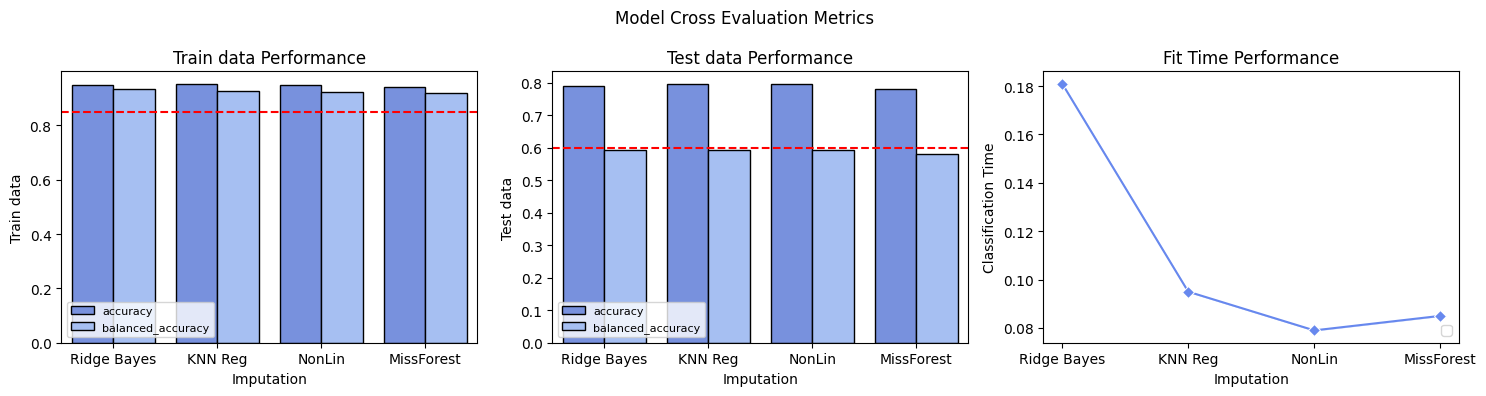

In [38]:
# Filter the metrics you want to plot (Fit Time, Accuracy, Balanced Accuracy, ROC AUC)
metrics_to_plot = ['accuracy', 'balanced_accuracy', 'roc_auc_ovr_weighted']
filtered_df_evaluation = prediction_df[prediction_df['Metric'].isin(metrics_to_plot)]
filtered_df_evaluation

sns.set_palette("coolwarm")
fig, axs = plt.subplots(1,3, figsize = (15, 4))

plt.suptitle("Model Cross Evaluation Metrics")
sns.barplot(data=filtered_df_evaluation, x='Imputation', y='Train data', hue='Metric', edgecolor='black', ax = axs[0])
axs[0].legend(loc="lower left",  fontsize=8)
axs[0].axhline(y=0.85, color='red', linestyle='--', linewidth=1.5) 
axs[0].set_title("Train data Performance")

sns.barplot(data=filtered_df_evaluation, x='Imputation', y='Test data', hue='Metric', edgecolor='black', ax = axs[1])
axs[1].legend(loc="lower left",  fontsize=8)
axs[1].axhline(y=0.60, color="red", linestyle="--", linewidth=1.5)
axs[1].set_title("Test data Performance")

sns.lineplot(data=filtered_df_evaluation, x='Imputation', y=filtered_df_evaluation['Classification Time'], marker="D", ax = axs[2])
axs[2].legend(loc="lower right")
axs[2].set_title("Fit Time Performance")

plt.tight_layout()